# I. Preparation

In [1]:
import os
import h5py
import time
import itertools

from math import log, sqrt
from statistics import stdev, variance, mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.stats import ttest_ind, ttest_1samp

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from fooof import FOOOF, FOOOFGroup
from fooof.plts.spectra import plot_spectrum, plot_spectrum_shading, plot_spectra, plot_spectra_shading
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
from fooof.objs.utils import combine_fooofs

from neurodsp.filt import filter_signal
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum

## 1. Function to read .mat files

In [2]:
def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()

## 2. Parameters that can be changed

In [3]:
# Days
days = ('/Day1', '/Day2')

# Subjects
subjects = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 
            'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 
            'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30']

In [4]:
# Parieto, parieto-occipital and occipital channels
channels = (17,18,19,20,21,22,23,24,25,26,27,29,30)
n_channels = 13

In [5]:
table = 2

# Frequency range to fit FOOOF model: Low, Mid, or High
fr = (3,20)

# Frequency range from which to collect Gaussians
bn = (3,9)

## 3. Parameters that should stay fixed

In [6]:
# Sampling rate
fs = 200

# nperseg
nperseg = 500

# Set peak_width_limits
pwl = [2, 4]

# Set max_n_peaks
mnp = 5

# Set peak_threshold
pt = 2 

# Initialize dataframe to store variables
df = pd.DataFrame([], index = [], columns = ['subject', 'day', 'target', \
                                             'offset', 'knee', 'exponent', \
                                             'CF', 'PW', 'BW', 'n_peaks', \
                                             'r_squared', 'error'])

# Colors
colors = ['blue', 'yellow', 'green', 'red']

# II. Fourier transform and FOOOF

In [7]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps): 
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)
                                    
                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)

        # Fit FOOOF model per target
        for (powers, target) in zip((powers_50, powers_55, powers_60, powers_65), \
                                    (50, 55, 60, 65)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     2.4872, 102.6628, 2.0745                                     
                                                              

C:\Users\ThinkPad\anaconda3\lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     0.4711, -1.6423, 0.5565                                      
                                                                                                  
                                       2 peaks were found:                                        
          

# III. Descriptive statistics
## 1. Summary

In [8]:
# Data types
display(df.dtypes)

subject      category
day          category
target       category
offset        float32
knee          float32
exponent      float32
CF            float32
PW            float32
BW            float32
n_peaks         int32
r_squared     float32
error         float32
dtype: object

In [9]:
# Head of dataframe
display(df.head(n=5))

,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,60,2.575504,110.889587,2.066221,6.448652,0.131256,2.0,4,0.875963,0.084074
1,S1,/Day2,50,2.476227,79.799011,2.106115,7.446962,0.205194,2.0,2,0.955792,0.076776
2,S1,/Day2,60,2.637844,134.310135,2.155900,6.389362,0.086946,2.0,3,0.963514,0.068488
3,S1,/Day2,65,3.130147,397.794403,2.751113,8.928272,0.485694,2.0,3,0.948914,0.087213
4,S2,/Day1,50,2.238204,25.191677,1.865300,5.989741,0.577807,2.0,2,0.914587,0.101412


In [10]:
# Summary statistics
display(pd.concat([df.describe(),\
                   pd.DataFrame(df.skew(), columns=['skewness']).transpose(),\
                   pd.DataFrame(df.kurtosis(), columns=['kurtosis']).transpose()]).round(2))

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
count,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00
mean,2.93,217324.19,2.43,6.67,0.31,2.08,2.07,0.93,0.07
std,1.58,1523910.25,1.18,1.05,0.18,0.35,0.69,0.06,0.03
min,-0.37,-2.12,0.11,3.20,0.03,2.00,1.00,0.68,0.03
25%,1.87,6.84,1.65,5.99,0.19,2.00,2.00,0.92,0.05
50%,2.84,126.52,2.35,6.44,0.27,2.00,2.00,0.95,0.07
75%,3.75,694.93,3.06,6.90,0.40,2.00,3.00,0.97,0.09
max,7.96,16731123.00,5.99,8.97,0.87,4.00,4.00,0.99,0.15
skewness,0.78,9.71,0.65,0.59,0.76,4.33,0.04,-2.51,0.87
kurtosis,0.90,101.96,0.31,1.07,0.17,18.30,-0.50,7.41,0.38


## 2. Univariate plots

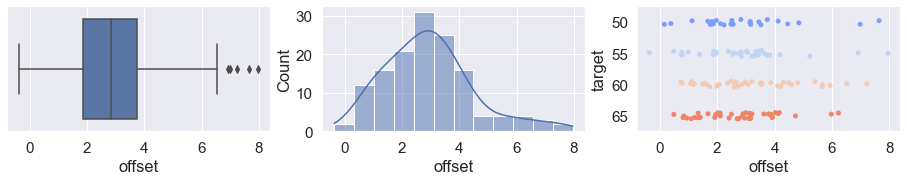

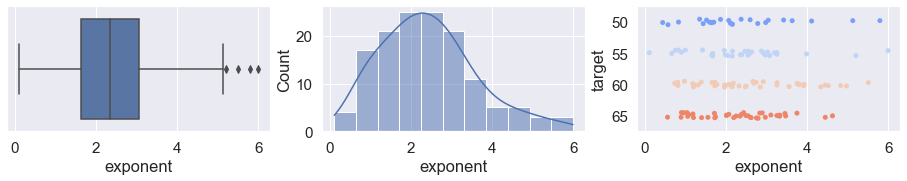

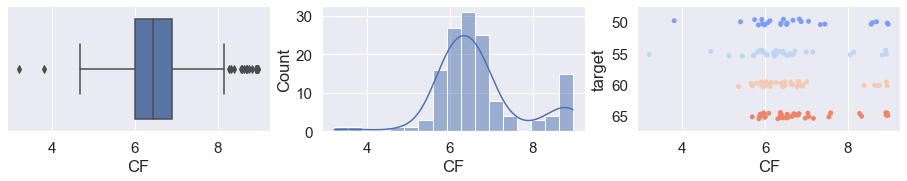

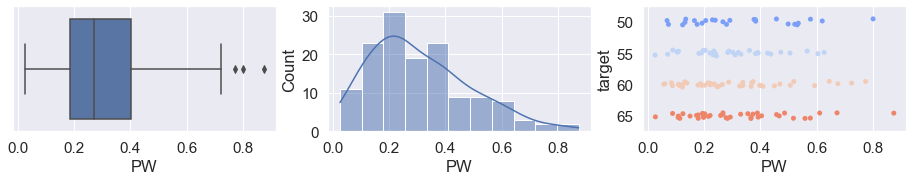

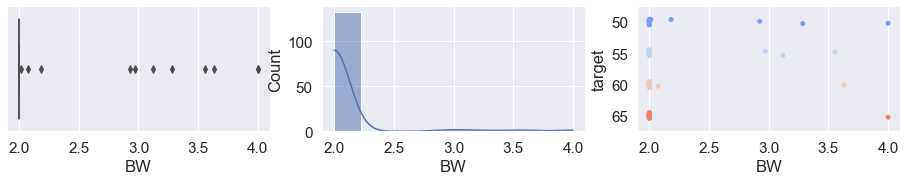

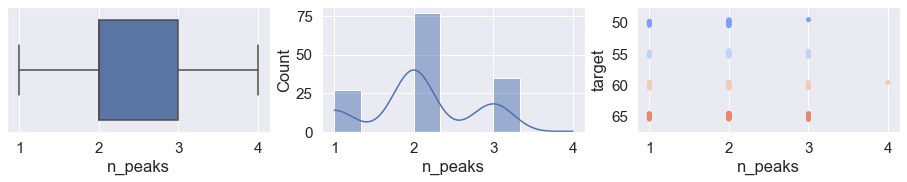

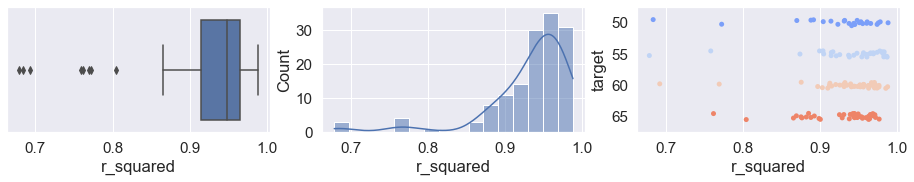

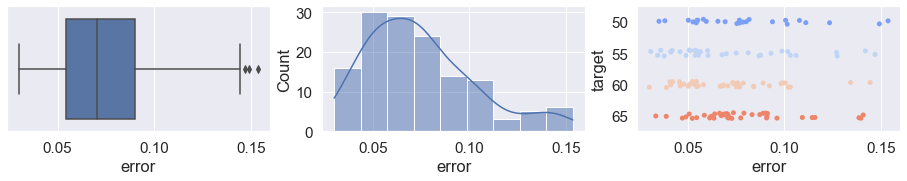

Done in 16.783s


In [11]:
tic = time.time()

df_num = df[['offset', 'exponent', 'CF', 'PW', 'BW', 'n_peaks', 'r_squared', 'error']]

for index, column in enumerate(df_num):
    sns.set(font_scale = 1.38)
    fig, ax = plt.subplots(1, 3, figsize=[16, 2.3])
    sns.boxplot(data=df_num, x=column, ax=ax[0])
    sns.histplot(data=df_num, x=column, kde=True,  ax=ax[1]) 
    sns.stripplot(data=df_num, x=column, y=df['target'], palette='coolwarm', ax=ax[2])
    plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 3. Bivariate plots

C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnin

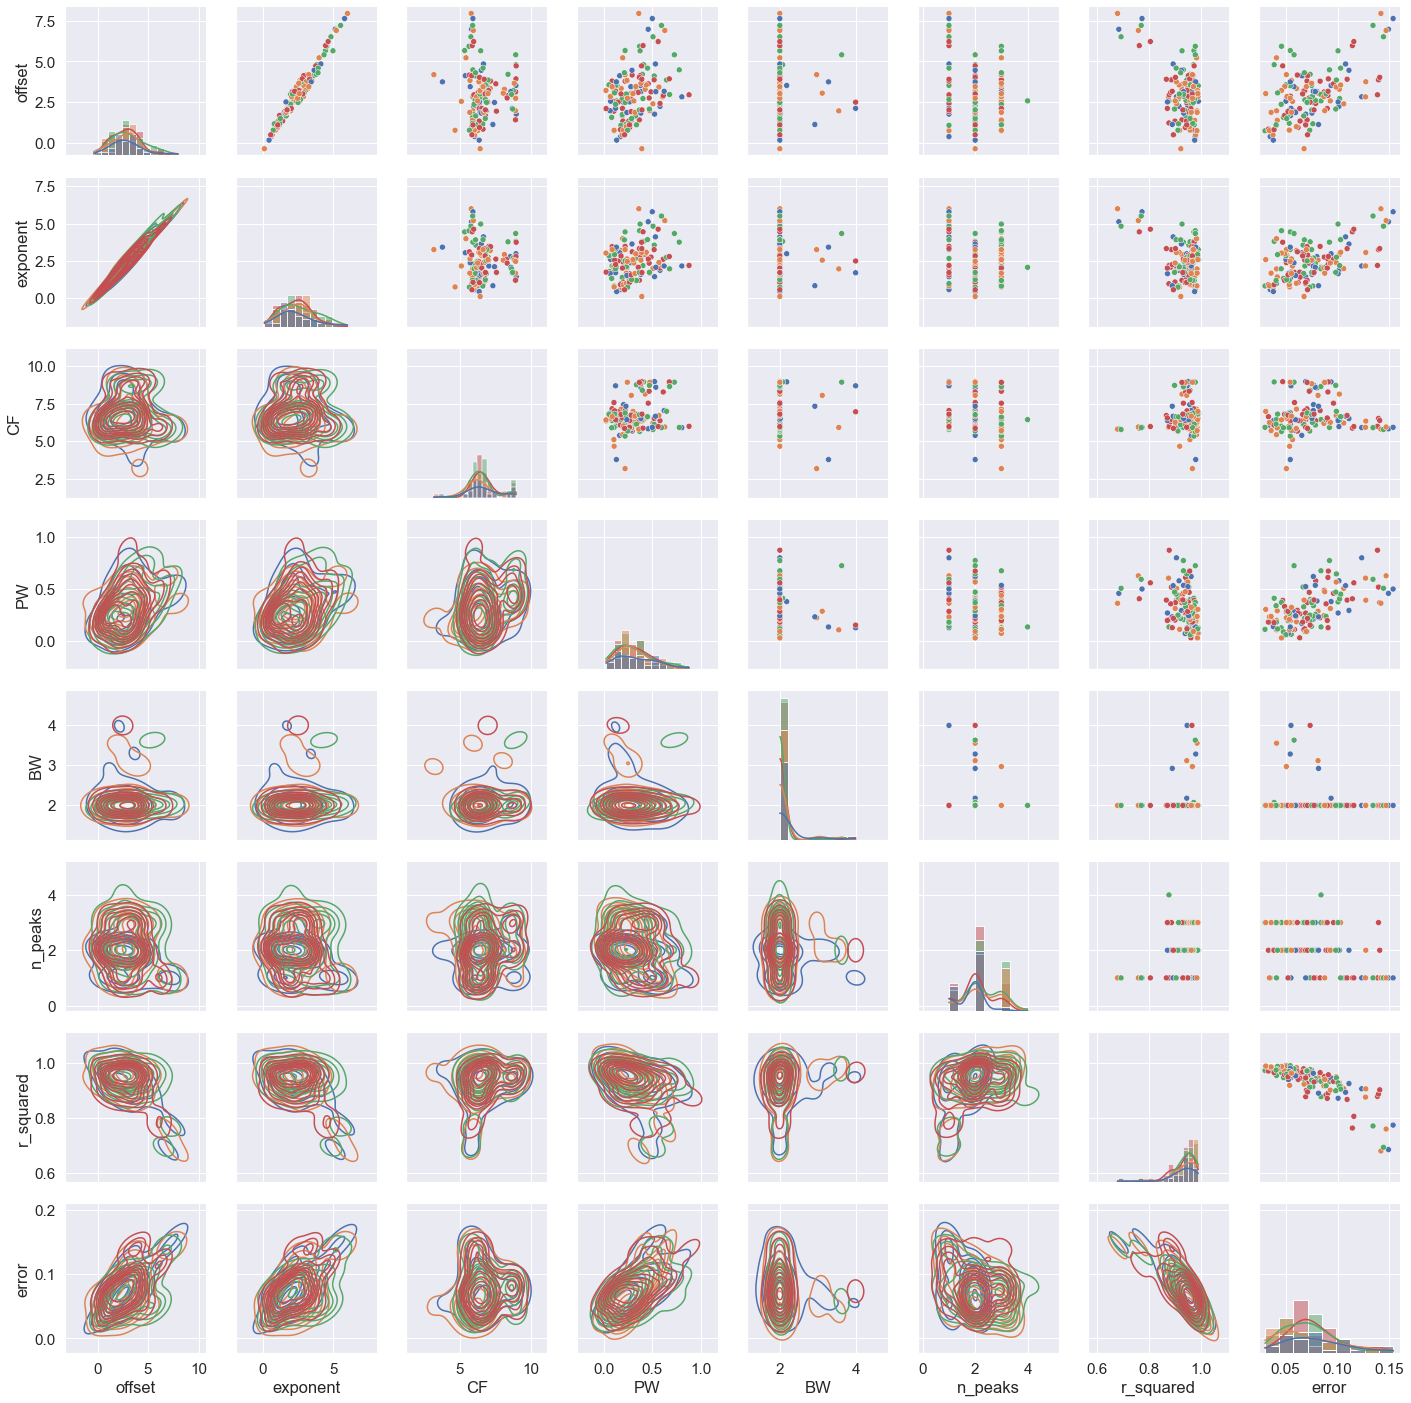

Done in 63.313s


In [12]:
tic = time.time()

g = sns.PairGrid(df_num)
g.map_upper(sns.scatterplot, hue=df['target'])
g.map_lower(sns.kdeplot, hue=df['target'], cmap = "Blues_d")
g.map_diag(sns.histplot, hue=df['target'], kde=True)
plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 4. Correlation matrix

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
offset,1.00,0.43,0.98,-0.02,0.38,0.01,-0.14,-0.51,0.56
knee,0.43,1.00,0.40,-0.11,0.10,-0.03,-0.22,-0.54,0.35
exponent,0.98,0.40,1.00,-0.01,0.31,0.03,-0.13,-0.43,0.51
CF,-0.02,-0.11,-0.01,1.00,0.26,0.06,0.02,0.16,0.02
PW,0.38,0.10,0.31,0.26,1.00,-0.09,-0.24,-0.39,0.61
BW,0.01,-0.03,0.03,0.06,-0.09,1.00,-0.06,0.11,-0.11
n_peaks,-0.14,-0.22,-0.13,0.02,-0.24,-0.06,1.00,0.35,-0.33
r_squared,-0.51,-0.54,-0.43,0.16,-0.39,0.11,0.35,1.00,-0.80
error,0.56,0.35,0.51,0.02,0.61,-0.11,-0.33,-0.80,1.00


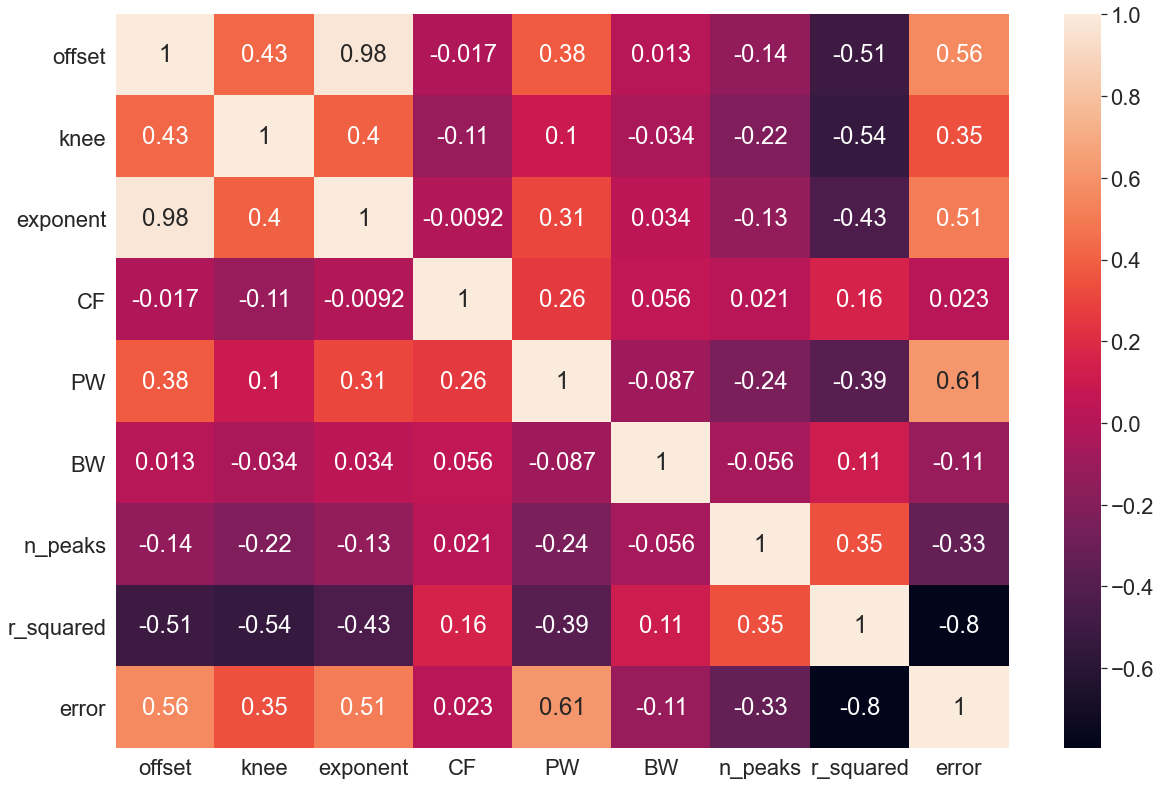

In [13]:
display(df.corr().round(2))

sns.set(font_scale = 2)
fig, heat = plt.subplots(figsize=(20,13.5))
heat = sns.heatmap(df.corr(), annot=True)
plt.show()

# IV. Classification
## Assign variables

In [14]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

# Initialize dataframe
performance = pd.DataFrame([], index = [], columns = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table'])

## 1. Logistic regression

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: 1.99891
Feature: 1, Score: 3.59157
Feature: 2, Score: -2.43556
Feature: 3, Score: 0.18097
Feature: 4, Score: -0.63725
Feature: 5, Score: 3.04179
Feature: 6, Score: -0.56420
Feature: 7, Score: 0.75203
Feature: 8, Score: 1.11260


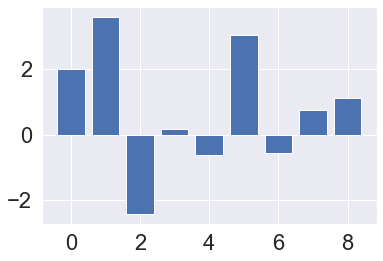

              precision    recall  f1-score   support

          50       0.40      0.22      0.29         9
          55       0.17      0.12      0.14         8
          60       0.00      0.00      0.00         5
          65       0.38      0.50      0.43         6

    accuracy                           0.21        28
   macro avg       0.24      0.21      0.21        28
weighted avg       0.26      0.21      0.22        28

Feature: 0, Score: 2.66957
Feature: 1, Score: 4.61698
Feature: 2, Score: -2.98918
Feature: 3, Score: 0.10475
Feature: 4, Score: -0.24233
Feature: 5, Score: 0.21089
Feature: 6, Score: -0.60987
Feature: 7, Score: 1.11288
Feature: 8, Score: 0.71784


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


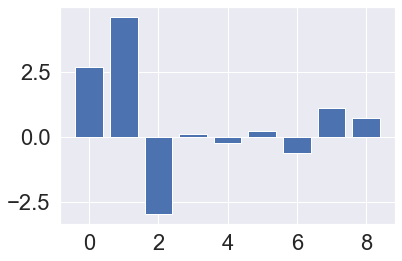

              precision    recall  f1-score   support

          50       0.00      0.00      0.00         3
          55       0.29      0.40      0.33         5
          60       0.25      0.25      0.25         8
          65       0.50      0.33      0.40        12

    accuracy                           0.29        28
   macro avg       0.26      0.25      0.25        28
weighted avg       0.34      0.29      0.30        28

Feature: 0, Score: 3.50872
Feature: 1, Score: 2.03144
Feature: 2, Score: -3.54287
Feature: 3, Score: 0.16216
Feature: 4, Score: -0.37503
Feature: 5, Score: 0.27186
Feature: 6, Score: -0.72197
Feature: 7, Score: 0.21147
Feature: 8, Score: 0.15105


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


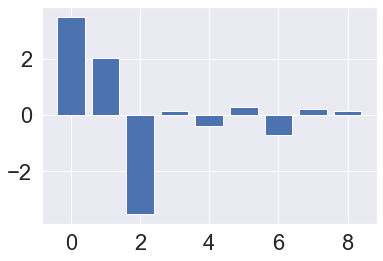

              precision    recall  f1-score   support

          50       0.00      0.00      0.00         1
          55       0.14      0.14      0.14         7
          60       0.25      0.22      0.24         9
          65       0.38      0.27      0.32        11

    accuracy                           0.21        28
   macro avg       0.19      0.16      0.17        28
weighted avg       0.26      0.21      0.24        28

Feature: 0, Score: 2.77521
Feature: 1, Score: 1.86407
Feature: 2, Score: -3.10415
Feature: 3, Score: -0.04384
Feature: 4, Score: -0.36026
Feature: 5, Score: 0.83243
Feature: 6, Score: -0.45769
Feature: 7, Score: 0.86491
Feature: 8, Score: 0.69306


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


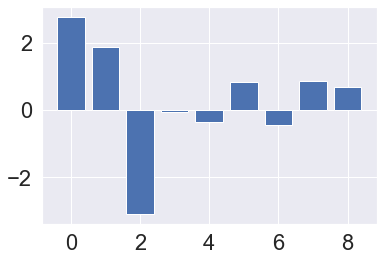

              precision    recall  f1-score   support

          50       0.00      0.00      0.00         2
          55       0.14      0.20      0.17         5
          60       0.38      0.27      0.32        11
          65       0.38      0.30      0.33        10

    accuracy                           0.25        28
   macro avg       0.22      0.19      0.20        28
weighted avg       0.31      0.25      0.27        28

Feature: 0, Score: 3.33572
Feature: 1, Score: 2.26169
Feature: 2, Score: -3.47198
Feature: 3, Score: 0.26570
Feature: 4, Score: -0.49357
Feature: 5, Score: 0.13781
Feature: 6, Score: -0.70198
Feature: 7, Score: 0.76564
Feature: 8, Score: 0.98179


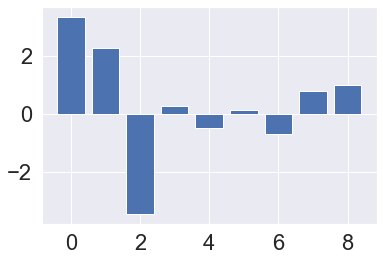

              precision    recall  f1-score   support

          50       0.00      0.00      0.00         5
          55       0.14      0.25      0.18         4
          60       0.50      0.44      0.47         9
          65       0.50      0.40      0.44        10

    accuracy                           0.32        28
   macro avg       0.29      0.27      0.27        28
weighted avg       0.36      0.32      0.34        28



In [15]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [16]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,35.1
knee,1.6
exponent,32.0
center of frequency,1.2
power,2.1
bandwidth,1.0
n peaks,1.2
R2,4.5
MAE,4.5


## 2. Ridge classifier

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.01391
Feature: 1, Score: -0.00333
Feature: 2, Score: -0.04514
Feature: 3, Score: 0.00501
Feature: 4, Score: -0.00506
Feature: 5, Score: 0.09296
Feature: 6, Score: -0.10636
Feature: 7, Score: -0.01525
Feature: 8, Score: 0.01631


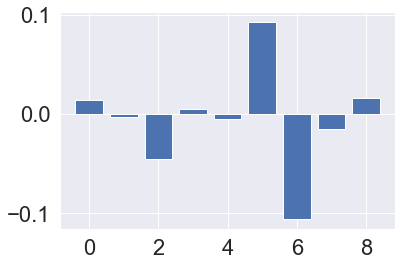

Alpha: 50.0
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         2
          55       0.17      0.50      0.25         2
          60       0.56      0.45      0.50        11
          65       0.25      0.15      0.19        13

    accuracy                           0.29        28
   macro avg       0.24      0.28      0.24        28
weighted avg       0.35      0.29      0.30        28

Feature: 0, Score: -0.00992
Feature: 1, Score: -0.00346
Feature: 2, Score: -0.04389
Feature: 3, Score: 0.02534
Feature: 4, Score: 0.01005
Feature: 5, Score: 0.05704
Feature: 6, Score: -0.10466
Feature: 7, Score: -0.01084
Feature: 8, Score: 0.05951


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


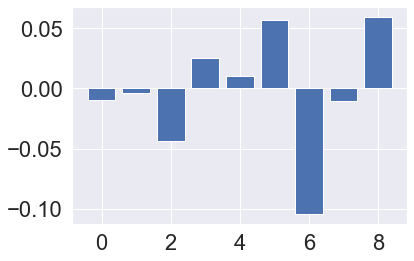

Alpha: 50.0
              precision    recall  f1-score   support

          50       0.20      1.00      0.33         1
          55       0.00      0.00      0.00         1
          60       0.62      0.29      0.40        17
          65       0.25      0.22      0.24         9

    accuracy                           0.29        28
   macro avg       0.27      0.38      0.24        28
weighted avg       0.47      0.29      0.33        28

Feature: 0, Score: 0.40227

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(



Feature: 1, Score: -0.01065
Feature: 2, Score: -0.40040
Feature: 3, Score: 0.03312
Feature: 4, Score: -0.03053
Feature: 5, Score: 0.14172
Feature: 6, Score: -0.09154
Feature: 7, Score: 0.12715
Feature: 8, Score: 0.20074


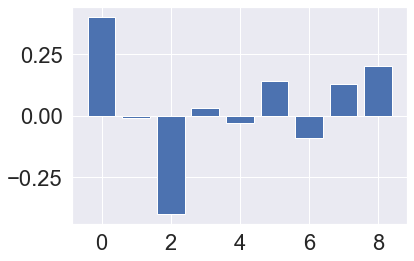

Alpha: 2.320794416806396
              precision    recall  f1-score   support

          50       0.20      0.17      0.18         6
          55       0.14      0.25      0.18         4
          60       0.38      0.25      0.30        12
          65       0.25      0.33      0.29         6

    accuracy                           0.25        28
   macro avg       0.24      0.25      0.24        28
weighted avg       0.28      0.25      0.25        28

Feature: 0, Score: 0.00594
Feature: 1, Score: -0.00246
Feature: 2, Score: -0.02538
Feature: 3, Score: 0.00361
Feature: 4, Score: -0.03107
Feature: 5, Score: 0.04722
Feature: 6, Score: -0.11091
Feature: 7, Score: 0.01024
Feature: 8, Score: 0.04078


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


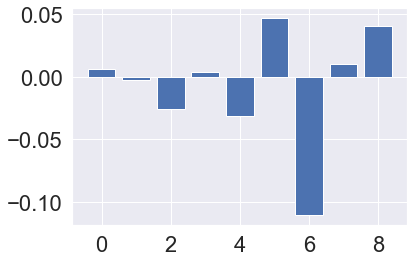

Alpha: 50.0
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         0
          60       0.38      0.38      0.38         8
          65       0.75      0.30      0.43        20

    accuracy                           0.32        28
   macro avg       0.28      0.17      0.20        28
weighted avg       0.64      0.32      0.41        28

Feature: 0, Score: -0.00716
Feature: 1, Score: -0.00377
Feature: 2, Score: -0.01058
Feature: 3, Score: 0.00626
Feature: 4, Score: 0.00412
Feature: 5, Score: 0.00557
Feature: 6, Score: -0.01718
Feature: 7, Score: -0.00341
Feature: 8, Score: 0.00334


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


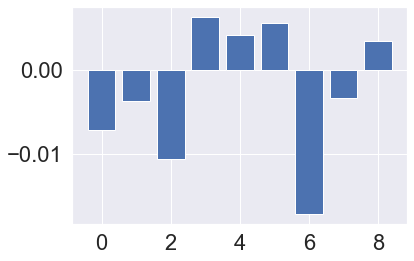

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         0
          60       0.38      0.23      0.29        13
          65       0.75      0.40      0.52        15

    accuracy                           0.32        28
   macro avg       0.28      0.16      0.20        28
weighted avg       0.58      0.32      0.41        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00714
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.03571
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


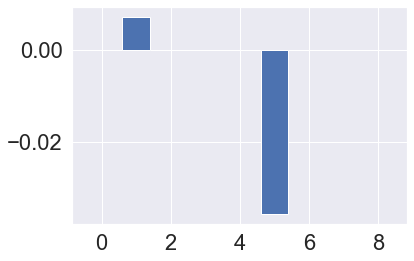

n_neighbors: 3
              precision    recall  f1-score   support

          50       0.20      0.07      0.11        14
          55       0.33      0.20      0.25        10
          60       0.11      1.00      0.20         1
          65       0.00      0.00      0.00         3

    accuracy                           0.14        28
   macro avg       0.16      0.32      0.14        28
weighted avg       0.22      0.14      0.15        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.00000
Feature: 1, Score: -0.00000
Feature: 2, Score: 0.00714
Feature: 3, Score: -0.00714
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.01429
Feature: 6, Score: -0.02857
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


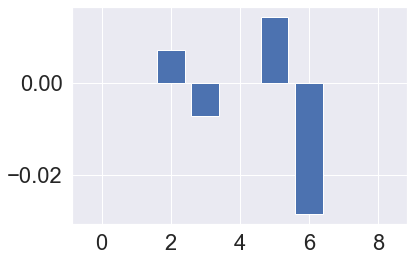

n_neighbors: 19
              precision    recall  f1-score   support

          50       0.20      0.50      0.29         2
          55       0.00      0.00      0.00         2
          60       0.38      0.20      0.26        15
          65       0.38      0.33      0.35         9

    accuracy                           0.25        28
   macro avg       0.24      0.26      0.22        28
weighted avg       0.34      0.25      0.27        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.05000
Feature: 1, Score: 0.00714
Feature: 2, Score: 0.05000
Feature: 3, Score: 0.01429
Feature: 4, Score: -0.01429
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.07857
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


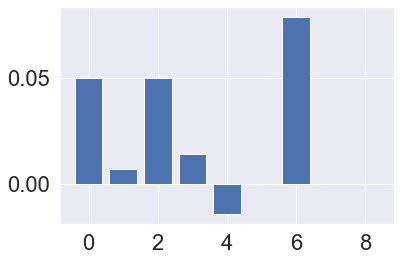

n_neighbors: 11
              precision    recall  f1-score   support

          50       0.20      0.33      0.25         3
          55       0.43      0.25      0.32        12
          60       0.38      0.38      0.38         8
          65       0.00      0.00      0.00         5

    accuracy                           0.25        28
   macro avg       0.25      0.24      0.24        28
weighted avg       0.31      0.25      0.27        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.02857
Feature: 1, Score: 0.02143
Feature: 2, Score: 0.02857
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.03571
Feature: 6, Score: 0.07143
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


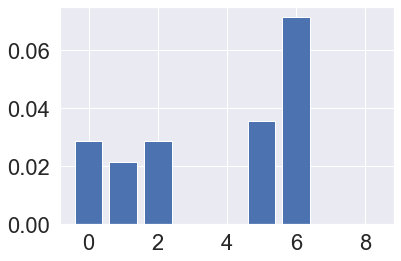

n_neighbors: 3
              precision    recall  f1-score   support

          50       0.20      0.17      0.18         6
          55       0.00      0.00      0.00         5
          60       0.12      0.14      0.13         7
          65       0.12      0.10      0.11        10

    accuracy                           0.11        28
   macro avg       0.11      0.10      0.11        28
weighted avg       0.12      0.11      0.11        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: -0.02143
Feature: 1, Score: 0.01429
Feature: 2, Score: -0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


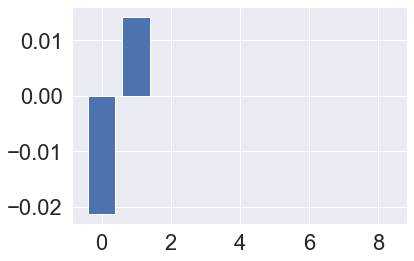

n_neighbors: 16
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         1
          55       0.14      0.50      0.22         2
          60       0.62      0.31      0.42        16
          65       0.38      0.33      0.35         9

    accuracy                           0.32        28
   macro avg       0.29      0.29      0.25        28
weighted avg       0.49      0.32      0.37        28



In [18]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [19]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Activation function: tanh
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.20      0.17      0.18         6
          55       0.17      0.07      0.10        15
          60       0.11      0.17      0.13         6
          65       0.00      0.00      0.00         1

    accuracy                           0.11        28
   macro avg       0.12      0.10      0.10        28
weighted avg       0.16      0.11      0.12        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Activation function: logistic
Solver: sgd
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         0
          60       1.00      0.29      0.44        28
          65       0.00      0.00      0.00         0

    accuracy                           0.29        28
   macro avg       0.25      0.07      0.11        28
weighted avg       1.00      0.29      0.44        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Activation function: tanh
Solver: adam
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         3
          55       0.14      0.10      0.12        10
          60       0.25      0.20      0.22        10
          65       0.12      0.20      0.15         5

    accuracy                           0.14        28
   macro avg       0.13      0.12      0.12        28
weighted avg       0.16      0.14      0.15        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Activation function: logistic
Solver: sgd
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         0
          60       1.00      0.29      0.44        28
          65       0.00      0.00      0.00         0

    accuracy                           0.29        28
   macro avg       0.25      0.07      0.11        28
weighted avg       1.00      0.29      0.44        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Activation function: logistic
Solver: sgd
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         0
          60       1.00      0.29      0.44        28
          65       0.00      0.00      0.00         0

    accuracy                           0.29        28
   macro avg       0.25      0.07      0.11        28
weighted avg       1.00      0.29      0.44        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5. Random forest

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.12368
Feature: 1, Score: 0.12349
Feature: 2, Score: 0.12602
Feature: 3, Score: 0.12472
Feature: 4, Score: 0.13236
Feature: 5, Score: 0.01923
Feature: 6, Score: 0.03443
Feature: 7, Score: 0.15933
Feature: 8, Score: 0.15674


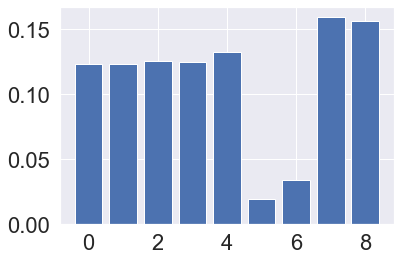

Number of trees: 1000
Maximum depth: 32
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         3
          55       0.33      0.29      0.31         7
          60       0.33      0.27      0.30        11
          65       0.12      0.14      0.13         7

    accuracy                           0.21        28
   macro avg       0.20      0.18      0.19        28
weighted avg       0.25      0.21      0.23        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.11975
Feature: 1, Score: 0.11556
Feature: 2, Score: 0.13389
Feature: 3, Score: 0.15634
Feature: 4, Score: 0.13022
Feature: 5, Score: 0.02743
Feature: 6, Score: 0.04024
Feature: 7, Score: 0.13594
Feature: 8, Score: 0.14062


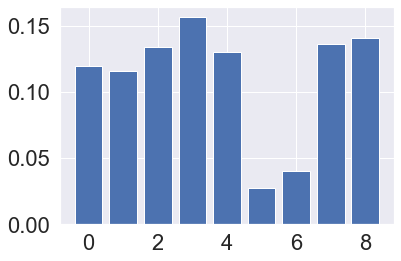

Number of trees: 2000
Maximum depth: 10
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         2
          55       0.43      0.33      0.38         9
          60       0.62      0.42      0.50        12
          65       0.25      0.40      0.31         5

    accuracy                           0.36        28
   macro avg       0.33      0.29      0.30        28
weighted avg       0.45      0.36      0.39        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.11104
Feature: 1, Score: 0.11600
Feature: 2, Score: 0.11409
Feature: 3, Score: 0.14002
Feature: 4, Score: 0.11796
Feature: 5, Score: 0.02692
Feature: 6, Score: 0.04058
Feature: 7, Score: 0.16348
Feature: 8, Score: 0.16992


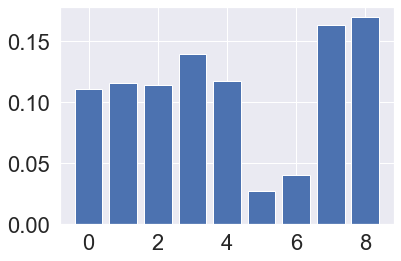

Number of trees: 200
Maximum depth: 32
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         1
          55       0.29      0.18      0.22        11
          60       0.38      0.33      0.35         9
          65       0.38      0.43      0.40         7

    accuracy                           0.29        28
   macro avg       0.26      0.24      0.24        28
weighted avg       0.33      0.29      0.30        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.12045
Feature: 1, Score: 0.11613
Feature: 2, Score: 0.12186
Feature: 3, Score: 0.14033
Feature: 4, Score: 0.13427
Feature: 5, Score: 0.02028
Feature: 6, Score: 0.04294
Feature: 7, Score: 0.14991
Feature: 8, Score: 0.15382


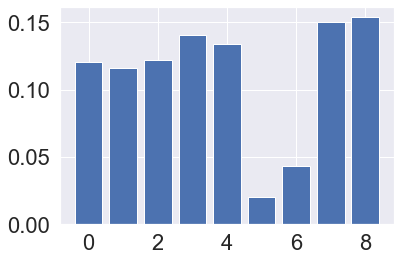

Number of trees: 200
Maximum depth: 55
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.14      0.25      0.18         4
          60       0.25      0.25      0.25         8
          65       0.50      0.25      0.33        16

    accuracy                           0.25        28
   macro avg       0.22      0.19      0.19        28
weighted avg       0.38      0.25      0.29        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.12417
Feature: 1, Score: 0.13467
Feature: 2, Score: 0.13686
Feature: 3, Score: 0.14703
Feature: 4, Score: 0.12357
Feature: 5, Score: 0.01358
Feature: 6, Score: 0.04474
Feature: 7, Score: 0.15172
Feature: 8, Score: 0.12367


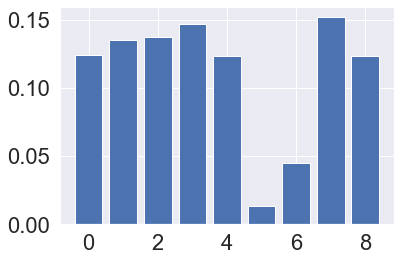

Number of trees: 200
Maximum depth: 10
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       0.20      0.14      0.17         7
          55       0.29      0.33      0.31         6
          60       0.12      0.17      0.14         6
          65       0.50      0.44      0.47         9

    accuracy                           0.29        28
   macro avg       0.28      0.27      0.27        28
weighted avg       0.30      0.29      0.29        28

Done in 1535.4981677532196 seconds


In [ ]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)    

print(f'Done in {time.time()-tic} seconds')

# Same for 3 channels
# I. Preparation

In [31]:
# Occipital channels
channels = (23,24,25) 
n_channels = 3

# II. Fourier transform and FOOOF

In [32]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)
                                        
        # Fit FOOOF model per target
        for (powers, target) in zip((powers_50, powers_55, powers_60, powers_65), \
                                    (50, 55, 60, 65)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    3.7756, 1955.7955, 3.1439                                     
                                                              

C:\Users\ThinkPad\anaconda3\lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


S27 /Day1 cnt_HIGH(2).mat
S27 /Day1 cnt_LOW(1).mat
S27 /Day1 cnt_LOW(2).mat
S27 /Day1 cnt_MID(1).mat
S27 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     1.6968, -1.2672, 1.4712                                      
                                                                                  

# IV. Classification
## Assign variables

In [33]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

## 1. Logistic regression

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: 3.27516
Feature: 1, Score: 32.80470
Feature: 2, Score: -3.40739
Feature: 3, Score: -0.04813
Feature: 4, Score: -0.22821
Feature: 5, Score: 0.09460
Feature: 6, Score: -0.24153
Feature: 7, Score: 0.45396
Feature: 8, Score: 0.60338


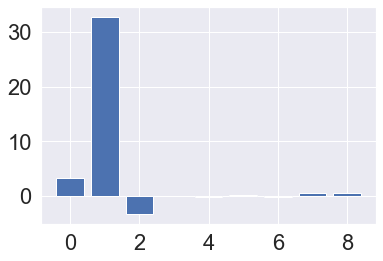

              precision    recall  f1-score   support

          50       0.13      0.25      0.17         8
          55       0.14      0.23      0.17        13
          60       0.65      0.50      0.57        34
          65       0.63      0.49      0.55        35

    accuracy                           0.43        90
   macro avg       0.39      0.37      0.37        90
weighted avg       0.52      0.43      0.47        90

Feature: 0, Score: 2.97815
Feature: 1, Score: 24.49643
Feature: 2, Score: -3.14566
Feature: 3, Score: -0.01818
Feature: 4, Score: -0.36976
Feature: 5, Score: 0.18115
Feature: 6, Score: -0.30901
Feature: 7, Score: 0.54333
Feature: 8, Score: 0.59091


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


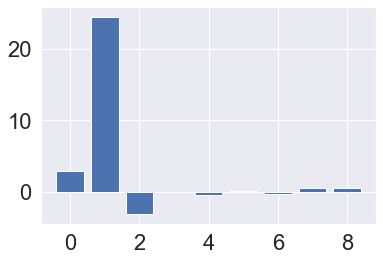

              precision    recall  f1-score   support

          50       0.13      0.22      0.17         9
          55       0.05      0.20      0.07         5
          60       0.46      0.38      0.41        32
          65       0.65      0.40      0.49        43

    accuracy                           0.36        89
   macro avg       0.32      0.30      0.29        89
weighted avg       0.50      0.36      0.41        89



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: 3.13185
Feature: 1, Score: 3.52196
Feature: 2, Score: -3.23506
Feature: 3, Score: -0.08626
Feature: 4, Score: -0.30441
Feature: 5, Score: 0.17091
Feature: 6, Score: -0.41147
Feature: 7, Score: 0.38070
Feature: 8, Score: 0.59206


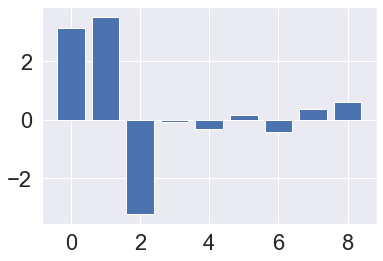

              precision    recall  f1-score   support

          50       0.19      0.75      0.30         4
          55       0.14      0.20      0.16        15
          60       0.32      0.32      0.32        25
          65       0.69      0.40      0.51        45

    accuracy                           0.36        89
   macro avg       0.33      0.42      0.32        89
weighted avg       0.47      0.36      0.39        89

Feature: 0, Score: 2.89720
Feature: 1, Score: -3.42522
Feature: 2, Score: -2.91107
Feature: 3, Score: -0.03949
Feature: 4, Score: -0.29915
Feature: 5, Score: 0.15086
Feature: 6, Score: -0.26285
Feature: 7, Score: 0.36099
Feature: 8, Score: 0.58911


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


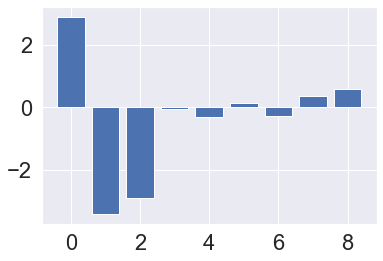

              precision    recall  f1-score   support

          50       0.06      0.20      0.10         5
          55       0.05      0.08      0.06        12
          60       0.44      0.37      0.40        30
          65       0.73      0.45      0.56        42

    accuracy                           0.36        89
   macro avg       0.32      0.28      0.28        89
weighted avg       0.50      0.36      0.41        89



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: 3.16468
Feature: 1, Score: 31.31985
Feature: 2, Score: -3.37284
Feature: 3, Score: -0.07387
Feature: 4, Score: -0.20793
Feature: 5, Score: 0.22081
Feature: 6, Score: -0.22224
Feature: 7, Score: 0.59855
Feature: 8, Score: 0.67958


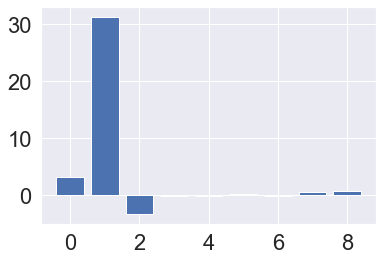

              precision    recall  f1-score   support

          50       0.13      0.40      0.20         5
          55       0.18      0.40      0.25        10
          60       0.60      0.54      0.57        28
          65       0.78      0.46      0.58        46

    accuracy                           0.47        89
   macro avg       0.42      0.45      0.40        89
weighted avg       0.62      0.47      0.51        89



In [34]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [35]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,47.2
knee,1.2
exponent,44.1
center of frequency,1.2
power,1.9
bandwidth,1.1
n peaks,1.2
R2,3.6
MAE,4.1


## 2. Ridge classifier

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: -0.00118
Feature: 1, Score: -0.00678
Feature: 2, Score: -0.00856
Feature: 3, Score: -0.00991
Feature: 4, Score: 0.00487
Feature: 5, Score: 0.00882
Feature: 6, Score: -0.01377
Feature: 7, Score: -0.00927
Feature: 8, Score: 0.01881


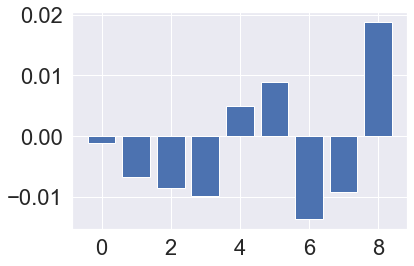

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         0
          60       0.54      0.36      0.43        39
          65       0.63      0.33      0.44        51

    accuracy                           0.34        90
   macro avg       0.29      0.17      0.22        90
weighted avg       0.59      0.34      0.43        90

Feature: 0, Score: -0.00677
Feature: 1, Score: -0.00598
Feature: 2, Score: -0.01350
Feature: 3, Score: -0.00717
Feature: 4, Score: -0.00136
Feature: 5, Score: 0.00822
Feature: 6, Score: -0.01667
Feature: 7, Score: -0.00654
Feature: 8, Score: 0.01204


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


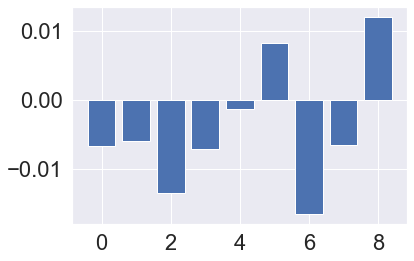

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         0
          60       0.38      0.48      0.43        21
          65       0.96      0.37      0.53        68

    accuracy                           0.39        89
   macro avg       0.34      0.21      0.24        89
weighted avg       0.83      0.39      0.51        89

Feature: 0, Score: -0.00280
Feature: 1, Score: -0.00638
Feature: 2, Score: -0.00920
Feature: 3, Score: -0.00771
Feature: 4, Score: 0.00408
Feature: 5, Score: 0.00901
Feature: 6, Score: -0.02290
Feature: 7, Score: -0.00788
Feature: 8, Score: 0.01751


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


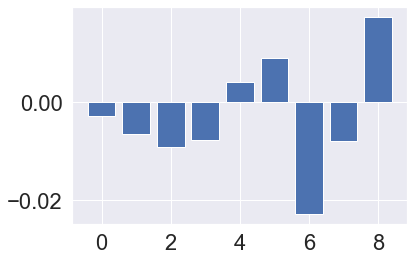

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         0
          60       0.68      0.44      0.53        39
          65       0.81      0.42      0.55        50

    accuracy                           0.43        89
   macro avg       0.37      0.21      0.27        89
weighted avg       0.75      0.43      0.54        89

Feature: 0, Score: 0.04810
Feature: 1, Score: -0.01600
Feature: 2, Score: -0.09947
Feature: 3, Score: -0.00880
Feature: 4, Score: -0.00253
Feature: 5, Score: 0.05373
Feature: 6, Score: -0.06727
Feature: 7, Score: 0.00272
Feature: 8, Score: 0.06339


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


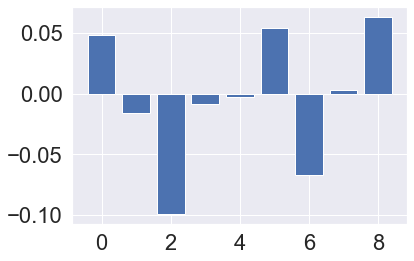

Alpha: 50.0
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         1
          55       0.05      0.33      0.08         3
          60       0.60      0.42      0.49        36
          65       0.69      0.37      0.48        49

    accuracy                           0.38        89
   macro avg       0.33      0.28      0.26        89
weighted avg       0.63      0.38      0.47        89

Feature: 0, Score: 0.86384
Feature: 1, Score: -0.01634
Feature: 2, Score: -0.89590
Feature: 3, Score: -0.00593
Feature: 4, Score: -0.09138
Feature: 5, Score: 0.02904
Feature: 6, Score: -0.10119
Feature: 7, Score: 0.17387
Feature: 8, Score: 0.20702


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


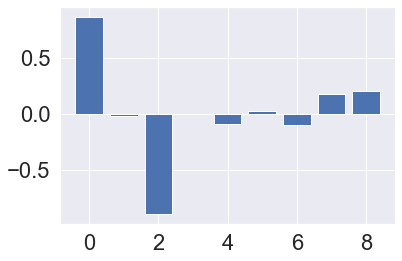

Alpha: 0.10772173450159434
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.05      0.17      0.07         6
          60       0.48      0.43      0.45        28
          65       0.85      0.42      0.56        55

    accuracy                           0.40        89
   macro avg       0.34      0.25      0.27        89
weighted avg       0.68      0.40      0.49        89



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.00444
Feature: 1, Score: 0.00000
Feature: 2, Score: -0.00889
Feature: 3, Score: 0.01778
Feature: 4, Score: 0.00889
Feature: 5, Score: -0.00222
Feature: 6, Score: -0.00444
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


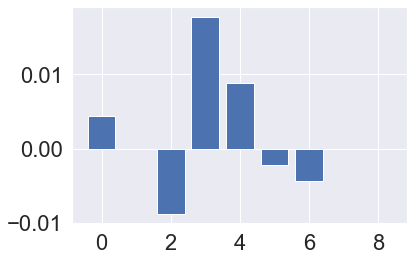

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.73      0.46      0.56        24
          55       0.41      0.53      0.46        17
          60       0.42      0.55      0.48        20
          65       0.67      0.62      0.64        29

    accuracy                           0.54        90
   macro avg       0.56      0.54      0.54        90
weighted avg       0.58      0.54      0.55        90



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.01348
Feature: 1, Score: 0.04045
Feature: 2, Score: 0.02472
Feature: 3, Score: 0.01348
Feature: 4, Score: 0.00225
Feature: 5, Score: -0.00225
Feature: 6, Score: 0.03146
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


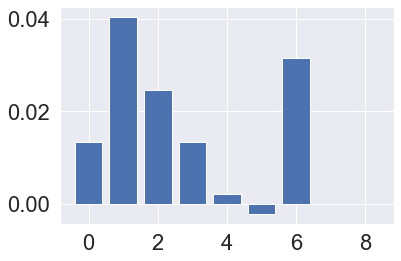

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.60      0.75      0.67        12
          55       0.82      0.67      0.73        27
          60       0.65      0.71      0.68        24
          65       0.81      0.81      0.81        26

    accuracy                           0.73        89
   macro avg       0.72      0.73      0.72        89
weighted avg       0.74      0.73      0.73        89



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.01573
Feature: 1, Score: 0.04270
Feature: 2, Score: 0.01573
Feature: 3, Score: 0.00674
Feature: 4, Score: 0.00674
Feature: 5, Score: 0.00225
Feature: 6, Score: 0.00225
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


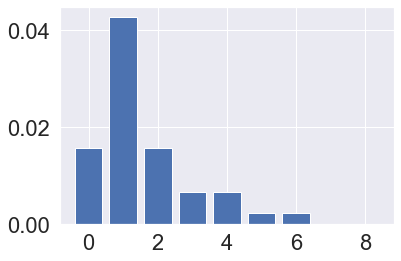

n_neighbors: 1
              precision    recall  f1-score   support

          50       1.00      1.00      1.00        16
          55       1.00      1.00      1.00        22
          60       1.00      1.00      1.00        25
          65       1.00      1.00      1.00        26

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.00674
Feature: 1, Score: 0.07191
Feature: 2, Score: 0.01573
Feature: 3, Score: 0.00899
Feature: 4, Score: 0.00899
Feature: 5, Score: 0.00449
Feature: 6, Score: 0.00899
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


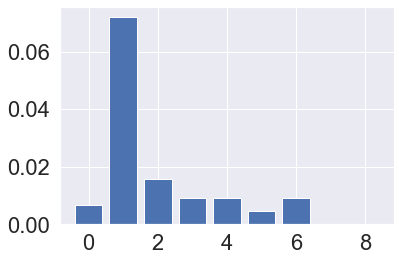

n_neighbors: 1
              precision    recall  f1-score   support

          50       1.00      1.00      1.00        16
          55       1.00      1.00      1.00        22
          60       1.00      1.00      1.00        25
          65       1.00      1.00      1.00        26

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.01573
Feature: 1, Score: 0.02472
Feature: 2, Score: 0.01348
Feature: 3, Score: 0.00225
Feature: 4, Score: -0.01124
Feature: 5, Score: 0.00899
Feature: 6, Score: 0.00449
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00225


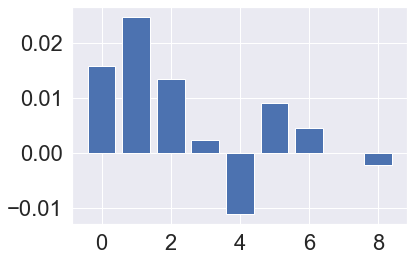

n_neighbors: 1
              precision    recall  f1-score   support

          50       1.00      1.00      1.00        15
          55       1.00      1.00      1.00        22
          60       1.00      1.00      1.00        25
          65       1.00      1.00      1.00        27

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



In [37]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [38]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.33      0.29      0.31        17
          55       0.32      0.54      0.40        13
          60       0.46      0.43      0.44        28
          65       0.63      0.53      0.58        32

    accuracy                           0.46        90
   macro avg       0.44      0.45      0.43        90
weighted avg       0.48      0.46      0.46        90



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.60      0.75      0.67        12
          55       0.64      0.61      0.62        23
          60       0.62      0.64      0.63        25
          65       0.85      0.76      0.80        29

    accuracy                           0.69        89
   macro avg       0.67      0.69      0.68        89
weighted avg       0.69      0.69      0.69        89



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

          50       1.00      1.00      1.00        16
          55       1.00      1.00      1.00        22
          60       1.00      1.00      1.00        25
          65       1.00      1.00      1.00        26

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-l

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

          50       1.00      1.00      1.00        16
          55       1.00      1.00      1.00        22
          60       1.00      1.00      1.00        25
          65       1.00      1.00      1.00        26

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89

Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

          50       1.00      1.00      1.00        15
          55       1.00      1.00      1.00        22
          60       1.00      1.00      1.00        25
          65       1.00      1.00      1.00        27

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



## 5. Random forest

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.10825
Feature: 1, Score: 0.11951
Feature: 2, Score: 0.11734
Feature: 3, Score: 0.17358
Feature: 4, Score: 0.12720
Feature: 5, Score: 0.02233
Feature: 6, Score: 0.03935
Feature: 7, Score: 0.14328
Feature: 8, Score: 0.14915


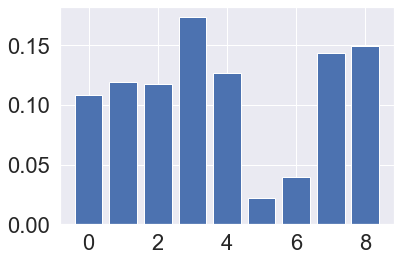

Number of trees: 200
Maximum depth: 32
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.47      0.41      0.44        17
          55       0.32      0.37      0.34        19
          60       0.54      0.61      0.57        23
          65       0.56      0.48      0.52        31

    accuracy                           0.48        90
   macro avg       0.47      0.47      0.47        90
weighted avg       0.48      0.48      0.48        90



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.10866
Feature: 1, Score: 0.11946
Feature: 2, Score: 0.11838
Feature: 3, Score: 0.16902
Feature: 4, Score: 0.13061
Feature: 5, Score: 0.01591
Feature: 6, Score: 0.04071
Feature: 7, Score: 0.14621
Feature: 8, Score: 0.15105


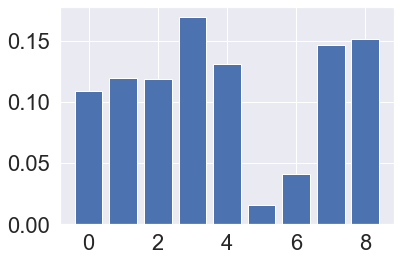

Number of trees: 200
Maximum depth: 77
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.60      0.82      0.69        11
          55       0.73      0.70      0.71        23
          60       0.65      0.77      0.71        22
          65       0.88      0.70      0.78        33

    accuracy                           0.73        89
   macro avg       0.72      0.75      0.72        89
weighted avg       0.75      0.73      0.73        89



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.11157
Feature: 1, Score: 0.11958
Feature: 2, Score: 0.11645
Feature: 3, Score: 0.17316
Feature: 4, Score: 0.12586
Feature: 5, Score: 0.02370
Feature: 6, Score: 0.04177
Feature: 7, Score: 0.13686
Feature: 8, Score: 0.15106


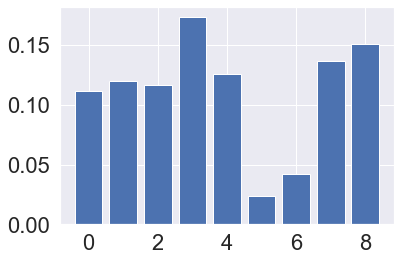

Number of trees: 1000
Maximum depth: 77
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       1.00      1.00      1.00        16
          55       1.00      1.00      1.00        22
          60       1.00      1.00      1.00        25
          65       1.00      1.00      1.00        26

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.11225
Feature: 1, Score: 0.11484
Feature: 2, Score: 0.11898
Feature: 3, Score: 0.18174
Feature: 4, Score: 0.12558
Feature: 5, Score: 0.01702
Feature: 6, Score: 0.04251
Feature: 7, Score: 0.14416
Feature: 8, Score: 0.14292


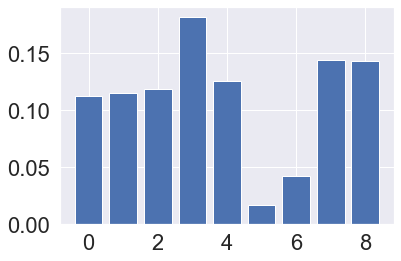

Number of trees: 200
Maximum depth: 100
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       1.00      1.00      1.00        16
          55       1.00      1.00      1.00        22
          60       1.00      1.00      1.00        25
          65       1.00      1.00      1.00        26

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Feature: 0, Score: 0.10870
Feature: 1, Score: 0.11976
Feature: 2, Score: 0.11864
Feature: 3, Score: 0.17713
Feature: 4, Score: 0.12509
Feature: 5, Score: 0.02147
Feature: 6, Score: 0.04305
Feature: 7, Score: 0.13734
Feature: 8, Score: 0.14881


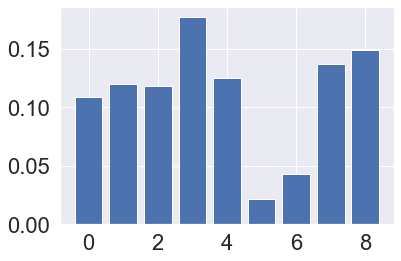

Number of trees: 2000
Maximum depth: 55
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       1.00      1.00      1.00        15
          55       1.00      1.00      1.00        22
          60       1.00      1.00      1.00        25
          65       1.00      1.00      1.00        27

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89

Done in 1189.9078199863434 seconds


In [39]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)  

print(f'Done in {time.time()-tic} seconds')

# V. Statistics

In [40]:
# Typecast dataframe
performance[['classifier', 'n_channels', 'table']] = performance[['classifier', 'n_channels', 'table']].astype('category')
performance[['accuracy', 'precision', 'recall']] = performance[['accuracy', 'precision', 'recall']].astype('float32')

# Save as csv
df.to_csv('df_table2.csv')
performance.to_csv('performance_table2.csv')

# Display
display(performance)
display(df)

,accuracy,precision,recall,classifier,n_channels,table
0,0.21,0.26,0.21,log,13,2
1,0.29,0.34,0.29,log,13,2
2,0.21,0.26,0.21,log,13,2
3,0.25,0.31,0.25,log,13,2
4,0.32,0.36,0.32,log,13,2
...,...,...,...,...,...,...
70,0.48,0.48,0.48,RF,3,2
71,0.73,0.75,0.73,RF,3,2
72,1.00,1.00,1.00,RF,3,2
73,1.00,1.00,1.00,RF,3,2


,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,60,2.575504,110.889587,2.066221,6.448652,0.131256,2.0,4,0.875963,0.084074
1,S1,/Day2,50,2.476227,79.799011,2.106115,7.446962,0.205194,2.0,2,0.955792,0.076776
2,S1,/Day2,60,2.637844,134.310135,2.155900,6.389362,0.086946,2.0,3,0.963514,0.068488
3,S1,/Day2,65,3.130147,397.794403,2.751113,8.928272,0.485694,2.0,3,0.948914,0.087213
4,S2,/Day1,50,2.238204,25.191677,1.865300,5.989741,0.577807,2.0,2,0.914587,0.101412
...,...,...,...,...,...,...,...,...,...,...,...,...
441,S30,/Day1,65,1.714805,3.682827,1.257452,6.718073,0.260314,2.0,2,0.936445,0.052786
442,S30,/Day2,50,1.860597,7.407424,1.493562,6.497082,0.331464,2.0,3,0.898569,0.091263
443,S30,/Day2,55,1.943061,9.971169,1.550166,6.621682,0.268942,2.0,2,0.943335,0.062469
444,S30,/Day2,60,2.142327,19.028496,1.654540,6.716576,0.320796,2.0,2,0.907675,0.080437


In [41]:
# Mean
display(pd.concat([performance.groupby(['classifier', 'n_channels']).agg({'accuracy': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'precision': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'recall': ['mean']})], axis=1))

# Standard error
print('log 13')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('log 3')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('Ridge 13')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('Ridge 3')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('KNN 13')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('KNN 3')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('MLP 13')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('MLP 3')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('RF 13')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('RF 3')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==3)], axis=0)/sqrt(5))

accuracy precision recall
                          mean      mean   mean
classifier n_channels                          
KNN        3             0.685     0.697  0.685
           13            0.214     0.296  0.214
MLP        3             0.659     0.674  0.659
           13            0.224     0.664  0.224
RF         3             0.684     0.715  0.684
           13            0.280     0.342  0.280
log        3             0.374     0.493  0.374
           13            0.256     0.306  0.256
ridge      3             0.380     0.686  0.380
           13            0.294     0.464  0.294

log 13


accuracy     0.019514
precision    0.018243
recall       0.019514
dtype: float64

log 3


accuracy     0.022645
precision    0.031308
recall       0.022645
dtype: float64

Ridge 13


accuracy     0.011524
precision    0.060438
recall       0.011524
dtype: float64

Ridge 3


accuracy     0.017776
precision    0.044820
recall       0.017776
dtype: float64

KNN 13


accuracy     0.034710
precision    0.055324
recall       0.034710
dtype: float64

KNN 3


accuracy     0.097494
precision    0.094785
recall       0.097494
dtype: float64

MLP 13


accuracy     0.036398
precision    0.184035
recall       0.036398
dtype: float64

MLP 3


accuracy     0.103662
precision    0.098878
recall       0.103662
dtype: float64

RF 13


accuracy     0.022271
precision    0.030646
recall       0.022271
dtype: float64

RF 3


accuracy     0.098330
precision    0.091329
recall       0.098330
dtype: float64

In [42]:
# One-sample t test
# log 13
accuracy = performance[(performance['classifier']=='log') & (performance['n_channels']==13)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))
# log 3
accuracy = performance[(performance['classifier']=='log') & (performance['n_channels']==3)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))

# Ridge 13
accuracy = performance[(performance['classifier']=='ridge') & (performance['n_channels']==13)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))
# Ridge 3
accuracy = performance[(performance['classifier']=='ridge') & (performance['n_channels']==3)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))

# KNN 13
accuracy = performance[(performance['classifier']=='KNN') & (performance['n_channels']==13)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))
# KNN 3
accuracy = performance[(performance['classifier']=='KNN') & (performance['n_channels']==3)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))

# MLP 13
accuracy = performance[(performance['classifier']=='MLP') & (performance['n_channels']==13)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))
# MLP 3
accuracy = performance[(performance['classifier']=='MLP') & (performance['n_channels']==3)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))

# RF 13
accuracy = performance[(performance['classifier']=='RF') & (performance['n_channels']==13)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))
# RF 3
accuracy = performance[(performance['classifier']=='RF') & (performance['n_channels']==3)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))

Ttest_1sampResult(statistic=0.27500874265658526, pvalue=0.7969300276171056)
Ttest_1sampResult(statistic=7.3465592466742144, pvalue=4.3431866281676694e-05)
Ttest_1sampResult(statistic=3.415062704469227, pvalue=0.026901899482986536)
Ttest_1sampResult(statistic=9.811516498346286, pvalue=4.191365762839527e-06)
Ttest_1sampResult(statistic=-0.927662869954492, pvalue=0.4060903370378369)
Ttest_1sampResult(statistic=5.986176486208209, pvalue=0.00020596413299019155)
Ttest_1sampResult(statistic=-0.6389157525938671, pvalue=0.5576289977044782)
Ttest_1sampResult(statistic=5.293466934382144, pvalue=0.0004981424399143113)
Ttest_1sampResult(statistic=1.204828888191535, pvalue=0.29467681907160875)
Ttest_1sampResult(statistic=5.921608669907912, pvalue=0.00022302389189606182)


In [43]:
## ANOVA and Tukey's test 
# Accuracy
model = ols('accuracy ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Precision
model = ols('precision ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Recall
model = ols('recall ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

,sum_sq,df,F,PR(>F)
C(classifier),0.644019,4.0,6.436622,1.993896e-04
C(n_channels),1.528131,1.0,61.091393,6.193312e-11
C(classifier):C(n_channels),0.457209,4.0,4.569562,2.586251e-03
Residual,1.625900,65.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   KNN    MLP   -0.014    0.9 -0.2462 0.2182  False
   KNN     RF   0.0213    0.9 -0.2109 0.2536  False
   KNN    log  -0.1933 0.1474 -0.4256 0.0389  False
   KNN  ridge  -0.1767 0.2192 -0.4089 0.0556  False
   MLP     RF   0.0353    0.9 -0.1969 0.2676  False
   MLP    log  -0.1793 0.2063 -0.4116 0.0529  False
   MLP  ridge  -0.1627 0.2957 -0.3949 0.0696  False
    RF    log  -0.2147 0.0838 -0.4469 0.0176  False
    RF  ridge   -0.198 0.1307 -0.4302 0.0342  False
   log  ridge   0.0167    0.9 -0.2156 0.2489  False
---------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     3     13  -0.3028 0.001 -0.3972 -0.2084   True
---------------------------------------------------


,sum_sq,df,F,PR(>F)
C(classifier),0.475845,4.0,3.031266,0.023541
C(n_channels),0.948833,1.0,24.177303,0.000006
C(classifier):C(n_channels),0.332111,4.0,2.115636,0.088853
Residual,2.550910,65.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP   0.1073 0.6939 -0.1319  0.3466  False
   KNN     RF   0.0273    0.9 -0.2119  0.2666  False
   KNN    log  -0.1327 0.5281 -0.3719  0.1066  False
   KNN  ridge   0.0487    0.9 -0.1906  0.2879  False
   MLP     RF    -0.08 0.8727 -0.3192  0.1592  False
   MLP    log    -0.24 0.0489 -0.4792 -0.0008   True
   MLP  ridge  -0.0587    0.9 -0.2979  0.1806  False
    RF    log    -0.16 0.3417 -0.3992  0.0792  False
    RF  ridge   0.0213    0.9 -0.2179  0.2606  False
   log  ridge   0.1813 0.2223 -0.0579  0.4206  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     3     13  -0.2386 0.001 -0.3433 -0.1339   True
--------------------------------------------------

,sum_sq,df,F,PR(>F)
C(classifier),0.644019,4.0,6.436622,1.993896e-04
C(n_channels),1.528131,1.0,61.091393,6.193312e-11
C(classifier):C(n_channels),0.457209,4.0,4.569562,2.586251e-03
Residual,1.625900,65.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   KNN    MLP   -0.014    0.9 -0.2462 0.2182  False
   KNN     RF   0.0213    0.9 -0.2109 0.2536  False
   KNN    log  -0.1933 0.1474 -0.4256 0.0389  False
   KNN  ridge  -0.1767 0.2192 -0.4089 0.0556  False
   MLP     RF   0.0353    0.9 -0.1969 0.2676  False
   MLP    log  -0.1793 0.2063 -0.4116 0.0529  False
   MLP  ridge  -0.1627 0.2957 -0.3949 0.0696  False
    RF    log  -0.2147 0.0838 -0.4469 0.0176  False
    RF  ridge   -0.198 0.1307 -0.4302 0.0342  False
   log  ridge   0.0167    0.9 -0.2156 0.2489  False
---------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     3     13  -0.3028 0.001 -0.3972 -0.2084   True
---------------------------------------------------
